In [1]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !echo '{"username":"your_username","key":"your_api_key"}' > ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json


In [2]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces -p /content/dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.75G/3.75G [02:07<00:00, 31.6MB/s]
100% 3.75G/3.75G [02:07<00:00, 31.5MB/s]


In [3]:
!kaggle datasets download -d ciplab/real-and-fake-face-detection -p /content/dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection
License(s): CC-BY-NC-SA-4.0
100% 430M/431M [00:15<00:00, 33.9MB/s]
100% 431M/431M [00:15<00:00, 29.2MB/s]


In [4]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm

In [5]:
def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )

    return model


In [6]:
base_path = '/content/dataset/real_vs_fake/real-vs-fake/train'
image_gen = ImageDataGenerator(rescale=1./255.,
                               rotation_range=20,
                               #shear_range=0.2,
                               #zoom_range=0.2,
                               horizontal_flip=True)

# Fix: Remove the extra 'train/' from the directory path
train_flow = image_gen.flow_from_directory(
    base_path,  # Use the base_path directly
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.


In [7]:
image_gen1 = ImageDataGenerator(rescale=1./255.)

# Update the path to the validation directory
valid_flow = image_gen1.flow_from_directory(
    '/content/dataset/real_vs_fake/real-vs-fake/valid', # Updated path for validation data
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1202s 380ms/step - accuracy: 0.6556 - loss: 0.6174 - val_accuracy: 0.7609 - val_loss: 0.4860
Epoch 2/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1127s 361ms/step - accuracy: 0.7686 - loss: 0.4818 - val_accuracy: 0.8176 - val_loss: 0.4010
Epoch 3/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1126s 360ms/step - accuracy: 0.8103 - loss: 0.4130 - val_accuracy: 0.8456 - val_loss: 0.3493
Epoch 4/4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1134s 363ms/step - accuracy: 0.8366 - loss: 0.3665 - val_accuracy: 0.8662 - val_loss: 0.3112


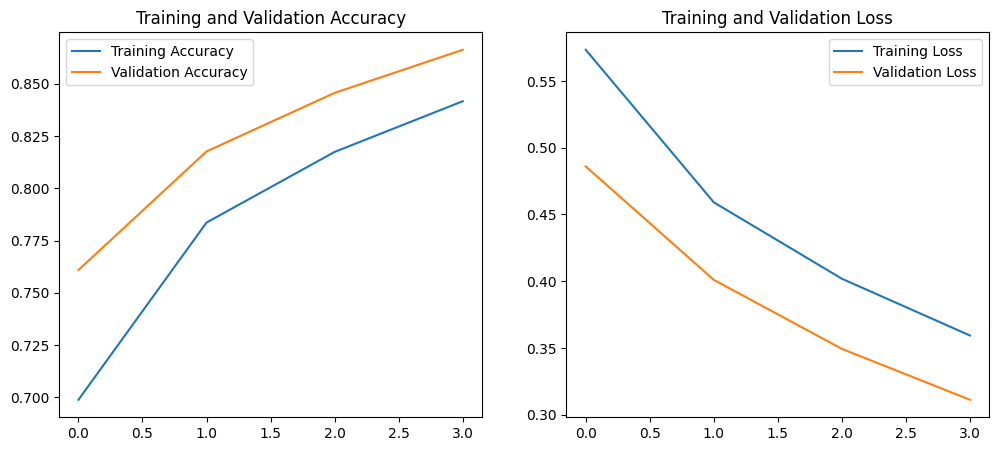

20000/20000 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step
ROC AUC Score: 0.9380624799999998
AP Score: 0.9357770822663062
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     10000
           1       0.85      0.87      0.86     10000

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000



In [8]:
# Install required libraries
!pip install keras-vggface opencv-python tqdm

# Import necessary libraries
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
# Instead of: from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Use tensorflow.keras for ImageDataGenerator
from sklearn import metrics

# Dataset paths
base_path = '/content/dataset/real_vs_fake/real-vs-fake/'

# Data Generators
batch_size = 32  # Reduced batch size for CPU optimization
image_gen = ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

image_gen1 = ImageDataGenerator(rescale=1./255.)
valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)
test_flow = image_gen1.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='binary'
)

# Model Definition
model = Sequential()
input_shape = (224, 224, 3)
activation = 'relu'
padding = 'same'
droprate = 0.1

model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(16, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Conv2D(64, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Conv2D(128, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Conv2D(256, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))

# Compile the Model
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the Model
train_steps = len(train_flow)
valid_steps = len(valid_flow)
history = model.fit(
    train_flow,
    epochs=5,
    steps_per_epoch=train_steps,
    validation_data=valid_flow,
    validation_steps=valid_steps
)

# Save the Model
model.save("custom_model_cpu_optimized.h5")

# Plot Training and Validation Loss/Accuracy
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

# Evaluate on Test Data
y_pred = model.predict(test_flow)
y_test = test_flow.classes

print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred > 0.5))


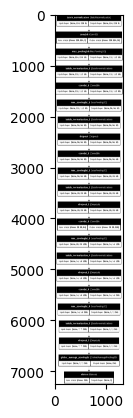

In [9]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Save model architecture with higher DPI for clarity
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True, dpi=300)

# Load and display the image with a larger figure size
img = plt.imread("model_architecture.png")
plt.figure(figsize=(15, 15))  # Increase figure size
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()


Found 20000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Extracting embeddings...
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 74ms/step
Explained variance ratio: [0.29395227 0.15848073]


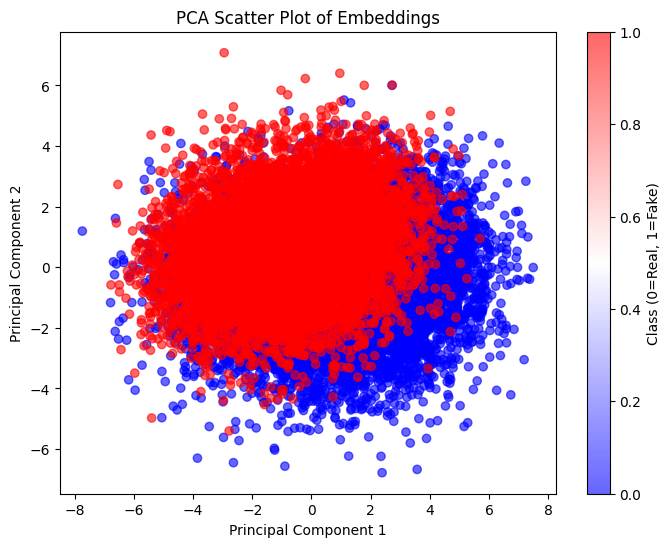

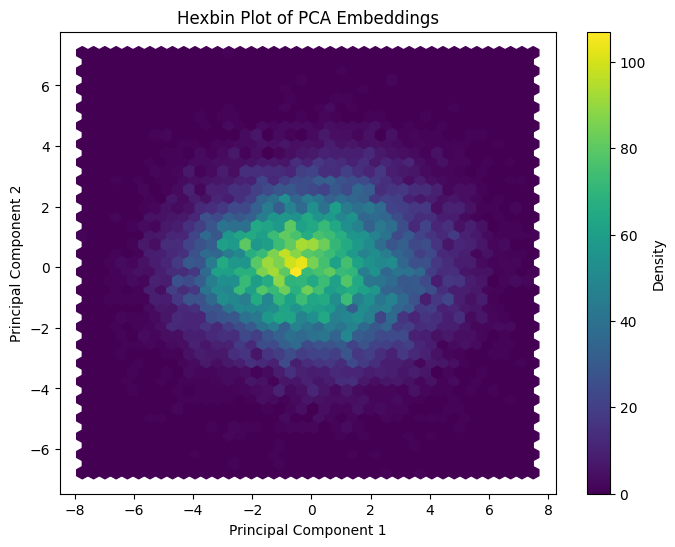

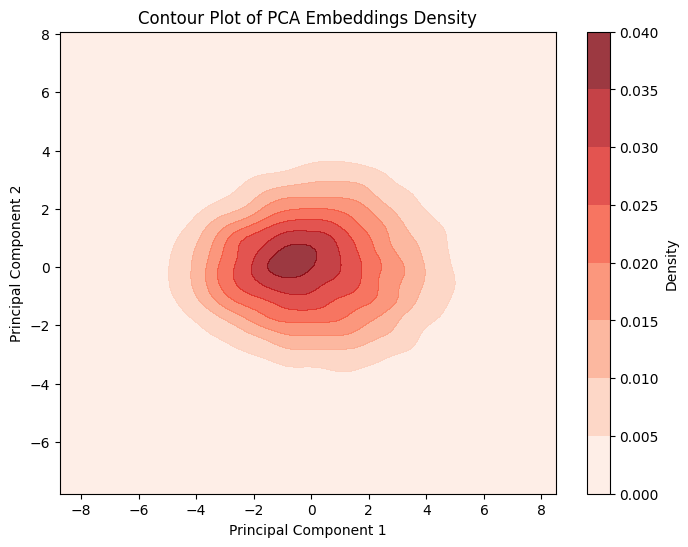

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.decomposition import IncrementalPCA
import scipy.stats as st

# Dataset paths
base_path = '/content/dataset/real_vs_fake/real-vs-fake/'

# Define data generators (for test data, no augmentation)
test_gen = ImageDataGenerator(rescale=1./255.)
test_flow = test_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=32,    # Increase batch size to reduce overhead
    shuffle=False,
    class_mode='binary'
)

# Load the saved custom CNN model
model = load_model("custom_model_cpu_optimized.h5")

# Create an embedder using the Functional API (extracting features from penultimate layer)
inp = Input(shape=(224, 224, 3))
x = inp
for layer in model.layers[:-1]:  # Exclude the final Dense layer (classifier)
    x = layer(x)
embedder = Model(inputs=inp, outputs=x)

# Extract embeddings from the test set using the embedder
print("Extracting embeddings...")
embeddings = embedder.predict(test_flow, verbose=1)
labels = test_flow.classes  # Order is preserved since shuffle=False

# Use IncrementalPCA to reduce dimensionality (processes data in batches to save memory)
ipca = IncrementalPCA(n_components=2, batch_size=1024)
ipca.fit(embeddings)
pca_result = ipca.transform(embeddings)
pc0 = pca_result[:, 0]
pc1 = pca_result[:, 1]

print("Explained variance ratio:", ipca.explained_variance_ratio_)

# Visualization: Scatter Plot of PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pc0, pc1, c=labels, cmap='bwr', alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot of Embeddings")
plt.colorbar(label="Class (0=Real, 1=Fake)")
plt.show()

# Visualization: Hexbin Plot
plt.figure(figsize=(8, 6))
hb = plt.hexbin(pc0, pc1, gridsize=40, cmap='viridis')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Hexbin Plot of PCA Embeddings")
plt.colorbar(hb, label='Density')
plt.show()

# Visualization: Contour Plot using KDE
xmin, xmax = pc0.min() - 1, pc0.max() + 1
ymin, ymax = pc1.min() - 1, pc1.max() + 1
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([pc0, pc1])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, f, cmap='Reds', alpha=0.8)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Contour Plot of PCA Embeddings Density")
plt.colorbar(label="Density")
plt.show()


In [11]:
# Save the Model
model.save("custom_model_cpu_optimized.h5")

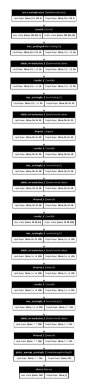

In [12]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
plt.imshow(plt.imread('model_architecture.png'))
plt.axis('off')
plt.show()

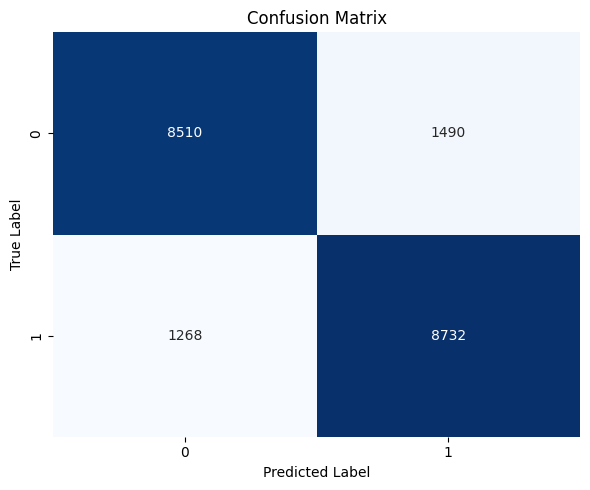

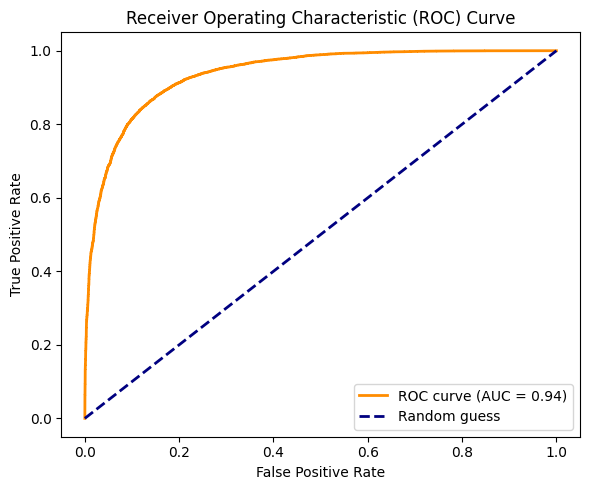

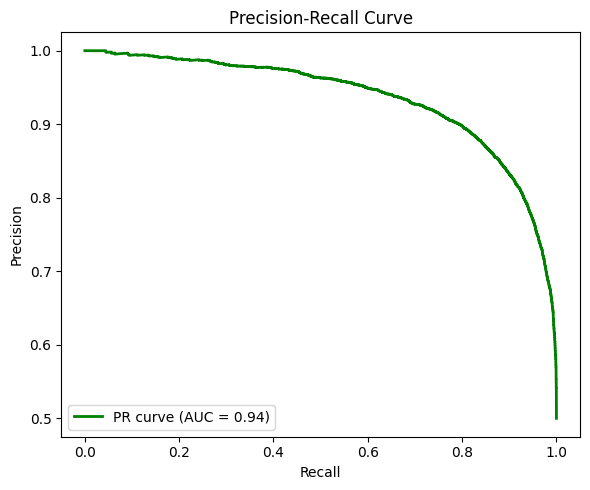

In [13]:
# %% [Additional Visualizations for Research Paper]
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

# Assuming y_pred and y_test are already computed from your trained model:
# y_pred = model.predict(test_flow) and y_test = test_flow.classes

# Convert model outputs to binary predictions using 0.5 as threshold
y_pred_binary = (y_pred > 0.5).astype(int)

# ----- Confusion Matrix -----
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ----- ROC Curve -----
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ----- Precision-Recall Curve -----
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', lw=2, label=f"PR curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

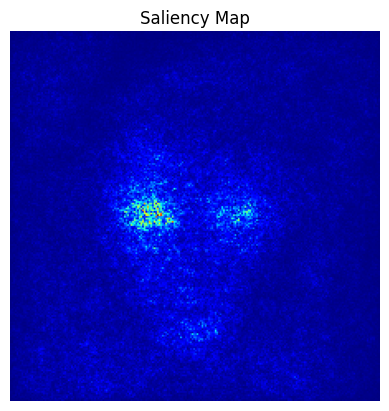

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def compute_saliency_map(model, img_array):
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor, training=False)
        loss = predictions[:, 0]  # For binary classification

    gradients = tape.gradient(loss, img_tensor)
    saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)[0]  # Max over color channels

    # Normalize for visualization
    saliency_map = (saliency_map - tf.reduce_min(saliency_map)) / (tf.reduce_max(saliency_map) + 1e-8)

    return saliency_map.numpy()

# Example usage
# Get one image for testing (Assuming test_flow is defined)
img_batch, label_batch = next(test_flow)
img = img_batch[0]
img_array = np.expand_dims(img, axis=0) # Add batch dimension if necessary


saliency_map = compute_saliency_map(model, img_array)

plt.imshow(saliency_map, cmap='jet')
plt.axis('off')
plt.title("Saliency Map")
plt.show()

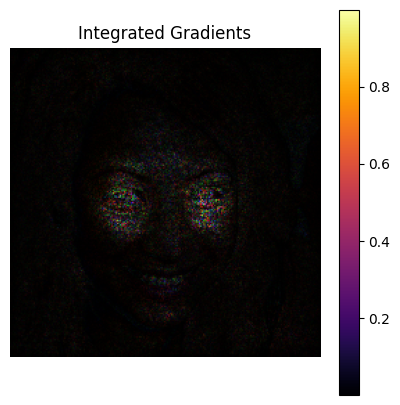

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def integrated_gradients(model, img_array, baseline=None, steps=100):
    """Compute Integrated Gradients (IG) heatmap."""
    if baseline is None:
        baseline = np.mean(img_array, axis=(1, 2), keepdims=True)

    alphas = np.linspace(0, 1, steps)
    baseline_tensor = tf.convert_to_tensor(baseline, dtype=tf.float32)
    img_array_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    interpolated_images = baseline_tensor + (img_array_tensor - baseline_tensor) * alphas[:, np.newaxis, np.newaxis, np.newaxis]

    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        predictions = model(interpolated_images)
        loss = predictions[:, 0]

    gradients = tape.gradient(loss, interpolated_images)
    avg_gradients = tf.reduce_mean(gradients, axis=0)

    ig_heatmap = (img_array - baseline) * avg_gradients

    ig_heatmap = np.abs(ig_heatmap[0])
    ig_heatmap = ig_heatmap / (np.max(ig_heatmap) + 1e-8)

    return ig_heatmap

# Get one image for testing
img_batch, label_batch = next(test_flow)
img = img_batch[0]
img_array = np.expand_dims(img, axis=0)

# Calculate the Integrated Gradients heatmap
heatmap = integrated_gradients(model, img_array, steps=100)

# Display the heatmap
plt.figure(figsize=(5, 5))
plt.imshow(heatmap, cmap="inferno")  # You can change the colormap if you prefer
plt.title("Integrated Gradients")
plt.colorbar()  # Add a colorbar to show the heatmap scale
plt.axis("off")  # Hide axis ticks and labels
plt.show()

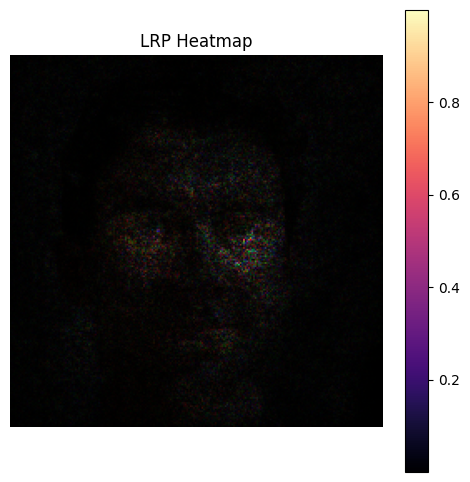

In [16]:
def lrp_heatmap(model, img_array):
    """Compute Layer-wise Relevance Propagation (LRP) heatmap."""
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)  # Convert to TensorFlow tensor
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)  # Watch the tensor
        prediction = model(img_tensor, training=False)  # Ensure model is in inference mode
        loss = prediction[:, 0]  # For binary classification, get the positive class score

    gradients = tape.gradient(loss, img_tensor)
    if gradients is None:
        # This means the loss was not dependent on any watched tensors
        # Returning a zero array of the same shape as img_array for visualization
        print("Warning: Gradients are None. This could mean there's no dependency between the loss and the watched tensors.")
        return np.zeros_like(img_array[0])

    relevance = gradients * img_tensor  # Element-wise relevance
    relevance = np.abs(relevance[0])  # Take absolute values of the first element
    relevance /= np.max(relevance) + 1e-8  # Normalize

    return relevance

# Get one image for testing
img_batch, label_batch = next(test_flow)
img = img_batch[0]
img_array = np.expand_dims(img, axis=0)  # Add batch dimension if necessary

# Compute LRP heatmap
lrp_map = lrp_heatmap(model, img_array)

# Visualization
plt.figure(figsize=(6, 6))
plt.imshow(lrp_map, cmap="magma")
plt.title("LRP Heatmap")
plt.axis("off")
plt.colorbar()
plt.show()

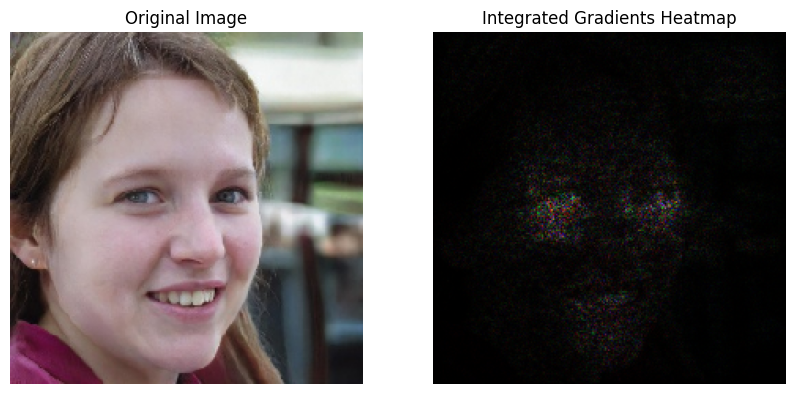

In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def integrated_gradients(model, img_array, baseline=None, steps=200):
    """Compute Integrated Gradients (IG) heatmap with correct broadcasting."""

    if baseline is None:
        # Set baseline as a black image of the same shape as img_array
        baseline = tf.zeros_like(img_array)

    # Generate interpolated images
    alphas = tf.reshape(tf.linspace(0.0, 1.0, steps), (steps, 1, 1, 1))  # Expand for broadcasting
    interpolated_images = baseline + (img_array - baseline) * alphas

    # Compute gradients
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        predictions = model(interpolated_images, training=False)
        loss = predictions[:, 0]  # Binary classification (adjust for multi-class)

    gradients = tape.gradient(loss, interpolated_images)

    # Average gradients across all steps
    avg_gradients = tf.reduce_mean(gradients, axis=0)

    # Compute IG attributions
    ig_attributions = (img_array - baseline) * avg_gradients

    # Normalize and return heatmap
    ig_heatmap = np.abs(ig_attributions.numpy()[0])
    ig_heatmap /= np.max(ig_heatmap) + 1e-8  # Normalize to [0,1]

    return ig_heatmap

# --- Example Usage ---
img_batch, label_batch = next(test_flow)  # Get a sample image
img = img_batch[0]
img_array = np.expand_dims(img, axis=0)  # Convert to batch format

# Generate the heatmap
heatmap = integrated_gradients(model, img_array)

# --- Visualization ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_array[0])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap="jet")  # 'inferno' or 'jet' for better contrast
plt.title("Integrated Gradients Heatmap")
plt.axis("off")

plt.show()


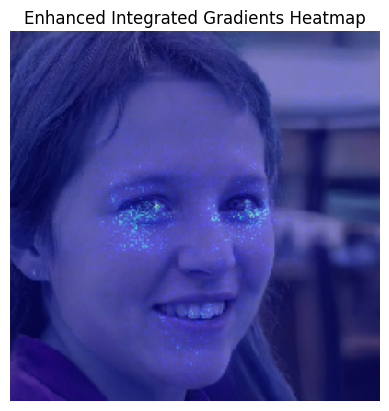

In [18]:
import cv2

# Apply a colormap for better visualization
def enhance_heatmap(heatmap, img_array, alpha=0.5):
    """Enhance heatmap by applying color mapping and overlaying on the original image."""

    heatmap = np.uint8(255 * heatmap)  # Normalize to 0-255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap

    # Resize heatmap to match image dimensions
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert original image to 0-255 for blending
    original_image = np.uint8(255 * img_array[0])

    # Overlay heatmap on original image
    superimposed_img = cv2.addWeighted(original_image, 1 - alpha, heatmap, alpha, 0)

    return superimposed_img

# Generate the enhanced heatmap
enhanced_img = enhance_heatmap(heatmap, img_array)

# Show the final image
plt.imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.title("Enhanced Integrated Gradients Heatmap")
plt.axis("off")
plt.show()


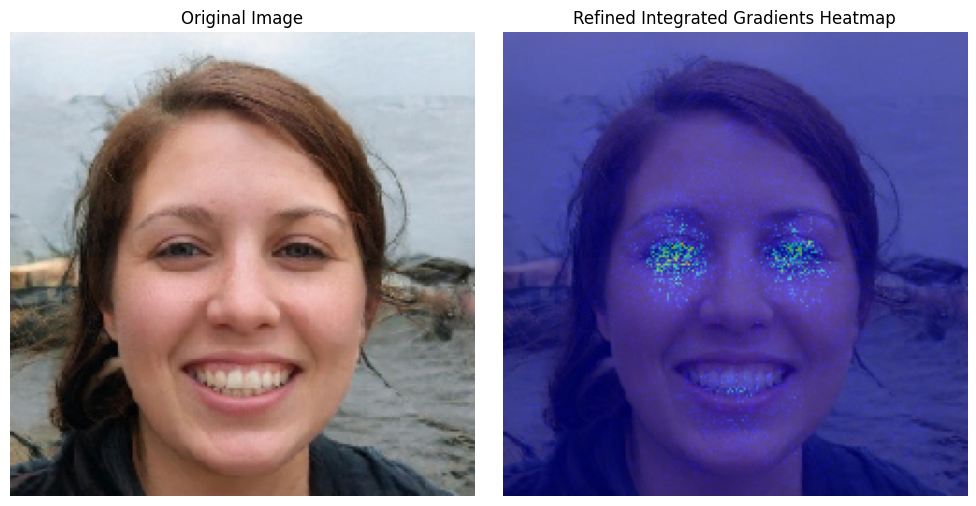

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def integrated_gradients(model, img_array, baseline=None, steps=200):
    """Compute Integrated Gradients (IG) with refined visualization."""

    if baseline is None:
        baseline = np.zeros_like(img_array)  # Black baseline image

    alphas = np.linspace(0, 1, steps)[:, np.newaxis, np.newaxis, np.newaxis]
    interpolated_images = baseline + alphas * (img_array - baseline)

    interpolated_images = tf.convert_to_tensor(interpolated_images, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        predictions = model(interpolated_images)
        loss = predictions[:, tf.argmax(predictions[0])]  # Focus on highest confidence class

    gradients = tape.gradient(loss, interpolated_images)
    avg_gradients = tf.reduce_mean(gradients, axis=0).numpy()

    ig_heatmap = np.abs(avg_gradients)
    ig_heatmap /= (np.max(ig_heatmap) + 1e-8)  # Normalize

    return ig_heatmap


def overlay_heatmap(img, heatmap, colormap=cv2.COLORMAP_JET, alpha=0.5):
    """Overlay heatmap on the original image with transparency control."""
    heatmap = (heatmap * 255).astype(np.uint8)  # Scale to 0-255
    heatmap = cv2.applyColorMap(heatmap, colormap)  # Apply colormap
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert to RGB

    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)  # Blend
    return overlay


# --- Load Sample Image ---
img_batch, label_batch = next(test_flow)  # Get image from test data
img = img_batch[0]
img_array = np.expand_dims(img, axis=0)

# Compute IG heatmap
heatmap = integrated_gradients(model, img_array)

# Generate refined heatmap overlay
refined_heatmap = overlay_heatmap((img * 255).astype(np.uint8), heatmap, colormap=cv2.COLORMAP_JET, alpha=0.6)

# --- Visualization ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_array[0])
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(refined_heatmap)
plt.title("Refined Integrated Gradients Heatmap")
plt.axis('off')

plt.tight_layout()
plt.show()


### SHAP

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.55s/it]               


<Figure size 800x500 with 0 Axes>

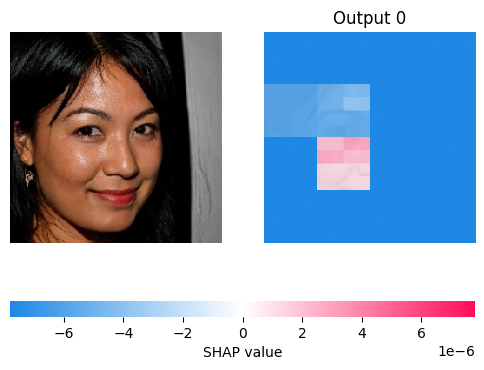

In [20]:
import shap
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from shap.maskers import Image

# --- Define SHAP Prediction Function ---
def f(images):
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    return model(images).numpy()

# --- Select an Image from Test Set ---
img_batch, label_batch = next(test_flow)
img = img_batch[0]
img_array = np.expand_dims(img, axis=0)  # Expand dimensions for model input

# --- Use SHAP ImageMasker ---
masker = Image("inpaint_telea", img.shape)  # Correct masker usage
explainer = shap.Explainer(f, masker)

# --- Compute SHAP Values ---
shap_values = explainer(img_array)

# --- Visualization ---
plt.figure(figsize=(8, 5))
shap.image_plot(shap_values, img_array)


# **LIME**

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ff9f18275fb9ce9d375d8f47f99035bc6c74683f85a38287c61d7c7e140ad100
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

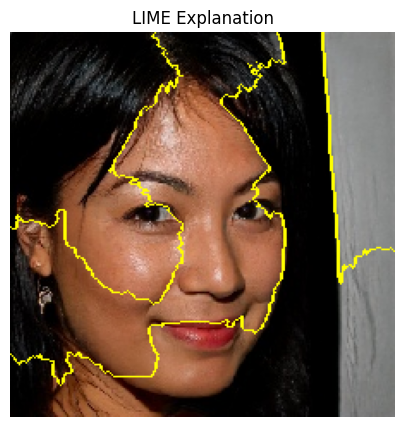

In [21]:
!pip install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Create LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the image
explanation = explainer.explain_instance(
    img.astype('double'),
    model.predict,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Get the explanation mask
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# --- Visualization ---
plt.figure(figsize=(8, 5))
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()


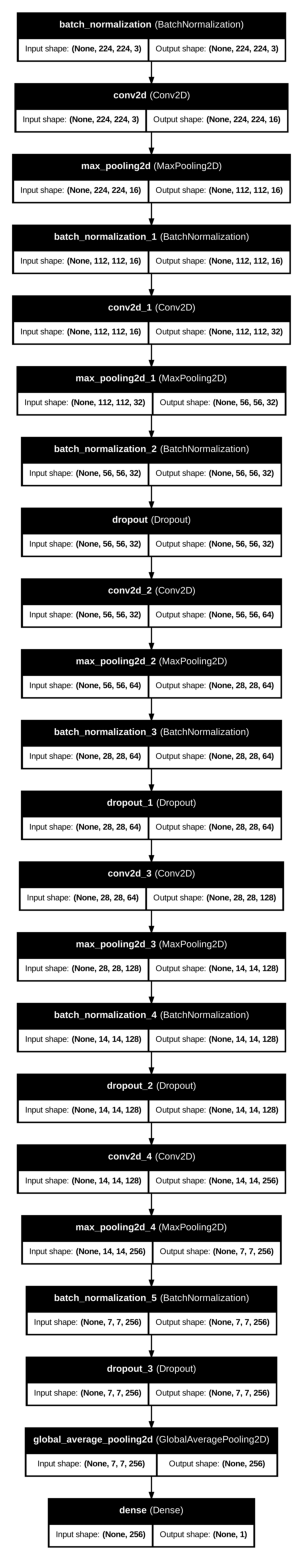

In [24]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Save the model architecture with an increased DPI for better resolution
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True, dpi=600)

# Load and display the image with a larger figure size
img = plt.imread("model_architecture.png")
plt.figure(figsize=(20, 20))  # Increase figure size further
plt.imshow(img)
plt.axis("off")  # Hide axes for a cleaner view
plt.show()


In [22]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !echo '{"username":"your_username","key":"your_api_key"}' > ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json


In [23]:
# Install required libraries
# !pip install tensorflow opencv-python tqdm scikit-learn matplotlib seaborn

# import tensorflow as tf
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# import matplotlib.pyplot as plt
# from sklearn import metrics
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # -------------------------------
# # 1. Data Preparation
# # -------------------------------
# base_path = '/content/dataset/real_vs_fake/real-vs-fake/'
# batch_size = 32
# target_size = (224, 224)

# # Aggressive data augmentation for training
# train_datagen = ImageDataGenerator(
#     rescale=1./255.,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2
# )
# # Simple rescaling for validation and test
# val_datagen = ImageDataGenerator(rescale=1./255.)
# test_datagen = ImageDataGenerator(rescale=1./255.)

# train_flow = train_datagen.flow_from_directory(
#     base_path + 'train/',
#     target_size=target_size,
#     batch_size=batch_size,
#     class_mode='binary'
# )
# val_flow = val_datagen.flow_from_directory(
#     base_path + 'valid/',
#     target_size=target_size,
#     batch_size=batch_size,
#     class_mode='binary'
# )
# test_flow = test_datagen.flow_from_directory(
#     base_path + 'test/',
#     target_size=target_size,
#     batch_size=1,
#     shuffle=False,
#     class_mode='binary'
# )

# # -------------------------------
# # 2. Build the Model using MobileNetV2 (Transfer Learning)
# # -------------------------------
# # Load the base model with pretrained ImageNet weights.
# base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
# base_model.trainable = False  # Freeze for initial training

# # Add a custom classification head.
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)  # Use high dropout to help generalization
# predictions = Dense(1, activation='sigmoid')(x)
# model = Model(inputs=base_model.input, outputs=predictions)

# # Compile the model (initial phase)
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# # -------------------------------
# # 3. Callbacks & Training Settings
# # -------------------------------
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
#     ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
# ]

# # Limit steps per epoch to use only a subset of the full generator (reduce from ~3125 to 2000)
# steps_per_epoch = 2000
# validation_steps = min(50, len(val_flow))  # Adjust as needed

# # -------------------------------
# # 4. Phase 1: Feature Extraction (Frozen Base)
# # -------------------------------
# initial_epochs = 5
# history_initial = model.fit(
#     train_flow,
#     epochs=initial_epochs,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=val_flow,
#     validation_steps=validation_steps,
#     callbacks=callbacks,
#     verbose=1
# )

# # -------------------------------
# # 5. Phase 2: Fine-Tuning (Unfreeze Last Layers)
# # -------------------------------
# # Unfreeze the last 30 layers of the base model for fine-tuning.
# base_model.trainable = True
# for layer in base_model.layers[:-30]:
#     layer.trainable = False

# # Recompile with a lower learning rate for fine-tuning.
# model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# # Increase fine-tuning epochs so that total epochs = initial_epochs + fine_tune_epochs = 5 + 15 = 20
# fine_tune_epochs = 15
# total_epochs = initial_epochs + fine_tune_epochs
# history_fine = model.fit(
#     train_flow,
#     epochs=total_epochs,
#     initial_epoch=initial_epochs,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=val_flow,
#     validation_steps=validation_steps,
#     callbacks=callbacks,
#     verbose=1
# )

# model.save("mobilenetv2_finetuned.h5")

# # -------------------------------
# # 6. Plot Training Metrics
# # -------------------------------
# # Combine histories for plotting
# train_acc = history_initial.history['accuracy'] + history_fine.history['accuracy']
# val_acc = history_initial.history['val_accuracy'] + history_fine.history['val_accuracy']
# train_loss = history_initial.history['loss'] + history_fine.history['loss']
# val_loss = history_initial.history['val_loss'] + history_fine.history['val_loss']

# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(train_acc, label='Train Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(train_loss, label='Train Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()

# # -------------------------------
# # 7. Evaluate on Test Data & Generate Confusion Matrix
# # -------------------------------
# y_pred = model.predict(test_flow)
# y_test = test_flow.classes
# roc_auc = metrics.roc_auc_score(y_test, y_pred)
# ap_score = metrics.average_precision_score(y_test, y_pred)

# print("ROC AUC Score:", roc_auc)
# print("Average Precision Score:", ap_score)
# print(metrics.classification_report(y_test, y_pred > 0.5))

# # Confusion Matrix
# y_pred_class = (y_pred > 0.5).astype("int32")
# cm = confusion_matrix(y_test, y_pred_class)
# print("Confusion Matrix:\n", cm)

# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()


Computing t-SNE projection...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


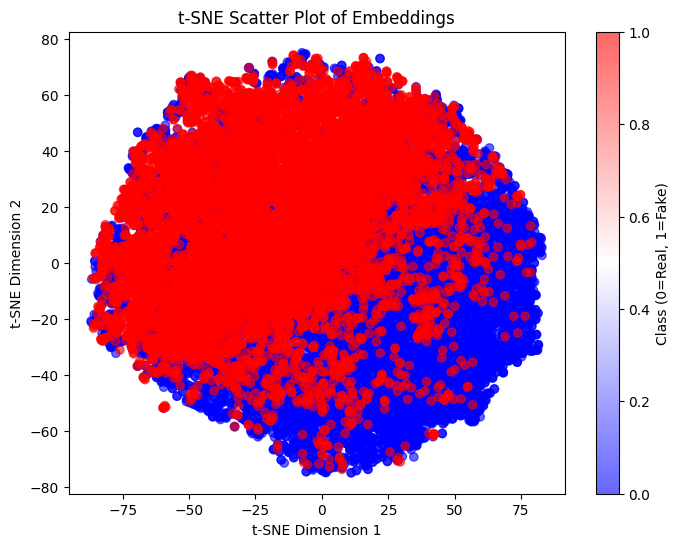

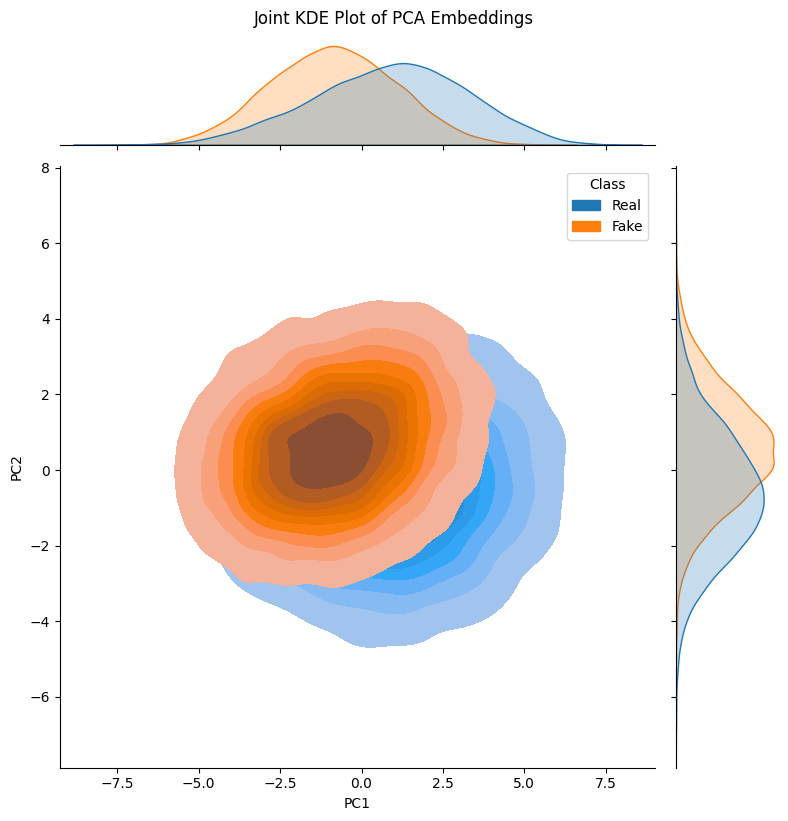

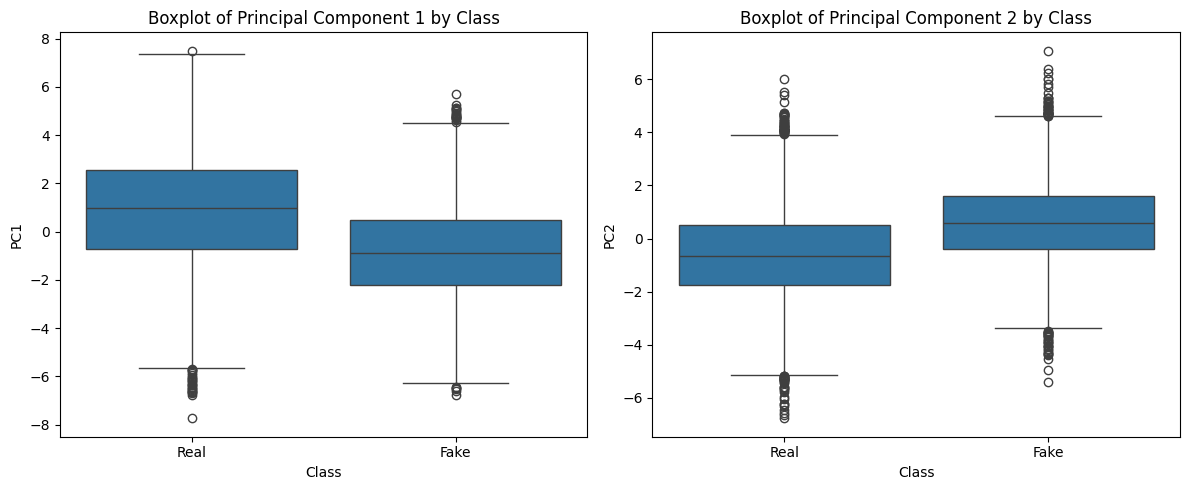

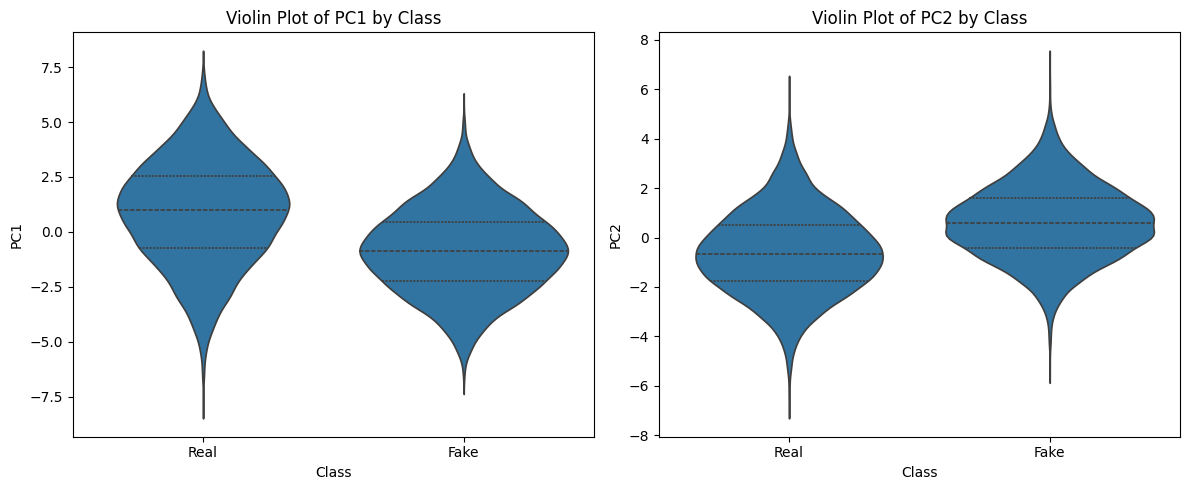

In [25]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

# -------------------------------
# Additional Visualization 1: t-SNE
# -------------------------------
print("Computing t-SNE projection...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(embeddings)
tsne_pc0 = tsne_result[:, 0]
tsne_pc1 = tsne_result[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(tsne_pc0, tsne_pc1, c=labels, cmap='bwr', alpha=0.6)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Scatter Plot of Embeddings")
plt.colorbar(label="Class (0=Real, 1=Fake)")
plt.show()


# -------------------------------
# Additional Visualization 2: Seaborn Joint Plot with KDE
# -------------------------------
# Create a DataFrame for easier plotting with Seaborn
df = pd.DataFrame({
    'PC1': pc0,
    'PC2': pc1,
    'Class': labels
})
# Map numeric labels to class names for clarity
df['Class'] = df['Class'].map({0: 'Real', 1: 'Fake'})

sns.jointplot(data=df, x='PC1', y='PC2', hue='Class', kind='kde', fill=True, height=8)
plt.suptitle("Joint KDE Plot of PCA Embeddings", y=1.02)
plt.show()


# -------------------------------
# Additional Visualization 3: Boxplots and Violin Plots
# -------------------------------
plt.figure(figsize=(12, 5))

# Boxplot for PC1 by class
plt.subplot(1, 2, 1)
sns.boxplot(x='Class', y='PC1', data=df)
plt.title("Boxplot of Principal Component 1 by Class")

# Boxplot for PC2 by class
plt.subplot(1, 2, 2)
sns.boxplot(x='Class', y='PC2', data=df)
plt.title("Boxplot of Principal Component 2 by Class")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

# Violin plot for PC1 by class
plt.subplot(1, 2, 1)
sns.violinplot(x='Class', y='PC1', data=df, inner='quartile')
plt.title("Violin Plot of PC1 by Class")

# Violin plot for PC2 by class
plt.subplot(1, 2, 2)
sns.violinplot(x='Class', y='PC2', data=df, inner='quartile')
plt.title("Violin Plot of PC2 by Class")
plt.tight_layout()
plt.show()
